## Glassdoor salary predictor

#### About Data and Research Ideas:

This data contains tech job posting from Glassdoor from 2017-2018 with features that can be used in order to:

* Predict the salary of a job based in this factors.

* Identify which of this factros most affects to Data Science related jobs.

In [2]:
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

wide = (21, 9) # Wide size for figure size.
large_square = (30, 30)

### Data Analysis and Preprocessing:

After a first check of our data (information and checking if there are null values in the dataset) we will load and split our data into a train set and a validation/test set, so we can test our work later. We will take a proportion of 90/10, where the train set consist in the 90% of total data and the test set represent the rest 10% of data.

The key here is to develope a dataset which can give us the best performance, in order to achive this we take in account several factors:

* Since our dataset is relatively short (743 rows) it is important to keep the number of the variables close to the the original 33; as we increase the number of variables we increase the complexity of the model and, consequently, its variance.



In [3]:
df = pd.read_csv('eda_data.csv').drop('Unnamed: 0', axis=1) # Droping the additional index loaded from data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          742 non-null    object 
 1   Salary Estimate    742 non-null    object 
 2   Job Description    742 non-null    object 
 3   Rating             742 non-null    float64
 4   Company Name       742 non-null    object 
 5   Location           742 non-null    object 
 6   Headquarters       742 non-null    object 
 7   Size               742 non-null    object 
 8   Founded            742 non-null    int64  
 9   Type of ownership  742 non-null    object 
 10  Industry           742 non-null    object 
 11  Sector             742 non-null    object 
 12  Revenue            742 non-null    object 
 13  Competitors        742 non-null    object 
 14  hourly             742 non-null    int64  
 15  employer_provided  742 non-null    int64  
 16  min_salary         742 non

In [5]:
df.isnull().any()[df.isnull().any() == True]

Series([], dtype: bool)

In [6]:
742*.9

667.8000000000001

In [7]:
train = df[:668]
test = df[668:]

In [8]:
train.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [9]:
train.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,age,python_yn,R_yn,spark,aws,excel,job_simp,seniority,desc_len,num_comp
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,47,1,0,0,0,1,data scientist,na,2536,0
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,36,1,0,0,0,0,data scientist,na,4783,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,10,1,0,1,0,1,data scientist,na,3461,0
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,55,1,0,0,0,0,data scientist,na,3883,3
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,22,1,0,0,0,1,data scientist,na,2728,3


In order to redeuce the number of variables we will quit:

* Job Title: Since there are 264 different descriptions and we have a simplified version of it with 7 possible values.
* Salary Estimate: We will take in account the variables max_salary, avg_salary and min_salary to study this factor.
* Job Description: Same idea as with Job Title.
* Age: It is the age of the Company, so it has the same meaning as Founded. We will use Founded.
* Company Name and company_txt: We will make the assumption that the name of a company is not related to their salaries (Since the length of the data set we can not afford to take this in account).
* Headquartes, Location, same_state and job_state: We will make the assumption that the location of the job and the location of the Headquartesr of the company does not affect to the salary. (Since the length of the data set we can not afford to take this in account).
* same_state: It is related to if the location of the job its the same as the location of the headquarters, so we cna drop it.
* Competitors: It refeers to the name of the competitors of the company, since we are talking about names of companies and we will try to get the information relative to the competition between peers with the Sector and Industry variables we can get rid of it.
* Industry: We have the Sector and the Industry variables. They have a very similar information so we will take the Sector since it is more general (25 unique values versus 60 unqique values for the Industry).
* min_salary / max_salary: Since we want to predict the salary we will only use the average; the min and the max can be outliers or suffer other statistical distorsion while the mean is more stable.
* desc_len: It is the length of the job description.


In [10]:
columns_dropped = {'Job Title', 'Salary Estimate', 'Job Description', 'Company Name', 'Headquarters' , 'same_state', 'Competitors', 'company_txt', 'job_state','Industry', 'desc_len', 'min_salary', 'max_salary', 'Location', 'age'}
train = train.drop(columns=columns_dropped)

In [11]:
train.head()

,Rating,Size,Founded,Type of ownership,Sector,Revenue,hourly,employer_provided,avg_salary,python_yn,R_yn,spark,aws,excel,job_simp,seniority,num_comp
0,3.8,501 to 1000 employees,1973,Company - Private,Aerospace & Defense,$50 to $100 million (USD),0,0,72.0,1,0,0,0,1,data scientist,na,0
1,3.4,10000+ employees,1984,Other Organization,Health Care,$2 to $5 billion (USD),0,0,87.5,1,0,0,0,0,data scientist,na,0
2,4.8,501 to 1000 employees,2010,Company - Private,Business Services,$100 to $500 million (USD),0,0,85.0,1,0,1,0,1,data scientist,na,0
3,3.8,1001 to 5000 employees,1965,Government,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),0,0,76.5,1,0,0,0,0,data scientist,na,3
4,2.9,51 to 200 employees,1998,Company - Private,Business Services,Unknown / Non-Applicable,0,0,114.5,1,0,0,0,1,data scientist,na,3


### One-hot encoding:

In order to treat the different category variables we will apply one hot enconding. There are many unique values in some variables hence an agrupation in this variables is needed.

In [12]:
train.head()

,Rating,Size,Founded,Type of ownership,Sector,Revenue,hourly,employer_provided,avg_salary,python_yn,R_yn,spark,aws,excel,job_simp,seniority,num_comp
0,3.8,501 to 1000 employees,1973,Company - Private,Aerospace & Defense,$50 to $100 million (USD),0,0,72.0,1,0,0,0,1,data scientist,na,0
1,3.4,10000+ employees,1984,Other Organization,Health Care,$2 to $5 billion (USD),0,0,87.5,1,0,0,0,0,data scientist,na,0
2,4.8,501 to 1000 employees,2010,Company - Private,Business Services,$100 to $500 million (USD),0,0,85.0,1,0,1,0,1,data scientist,na,0
3,3.8,1001 to 5000 employees,1965,Government,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),0,0,76.5,1,0,0,0,0,data scientist,na,3
4,2.9,51 to 200 employees,1998,Company - Private,Business Services,Unknown / Non-Applicable,0,0,114.5,1,0,0,0,1,data scientist,na,3


In [13]:
Size_dummy = pd.get_dummies(train.Size).drop(['Unknown', '-1'], axis=1)

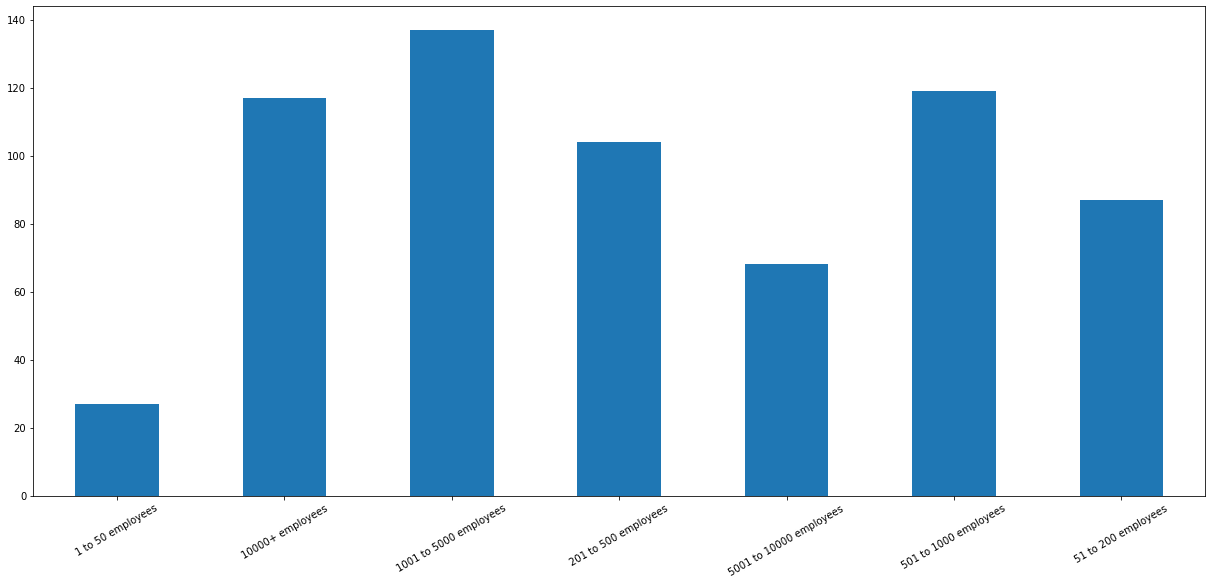

In [14]:
Size_dummy.sum().plot.bar(figsize=wide, rot=30);

In [15]:
Size_dummy['0 to 500 employees'] = Size_dummy['1 to 50 employees'] + Size_dummy['51 to 200 employees']
Size_dummy.drop(['1 to 50 employees', '51 to 200 employees'], axis=1, inplace=True)

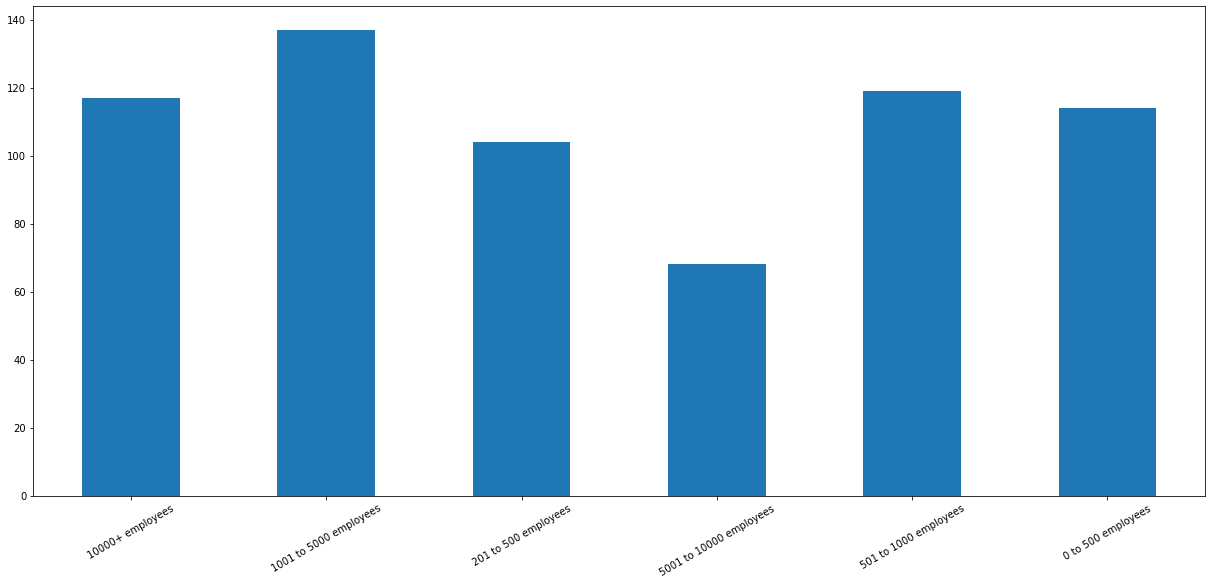

In [16]:
Size_dummy.sum().plot.bar(figsize=wide, rot=30);

In [17]:
train = pd.concat([train.drop('Size', axis=1), Size_dummy], axis=1)

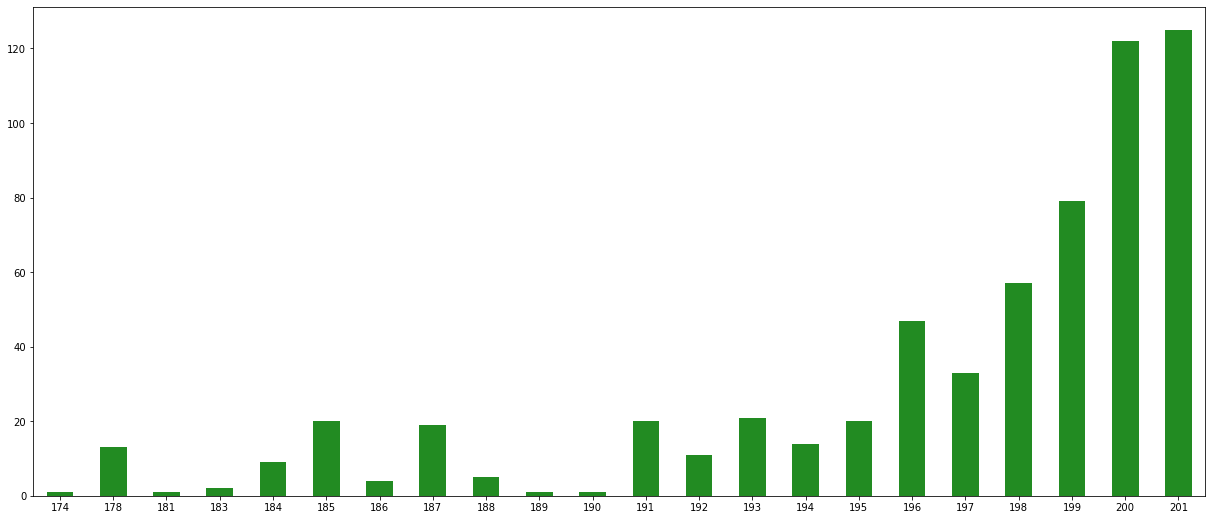

In [18]:
pd.get_dummies(train.Founded.astype('str').str[:3]).drop('-1', axis=1).sum().plot.bar(figsize=wide, rot=0, color='forestgreen'); # In each decade:

In [19]:
train['Founded before 1950'] = (train.Founded < 1950).astype('int')
train['Founded before 1951 and 2000'] = ((train.Founded >= 1951) & (train.Founded < 2000)).astype('int')
train['Founded after 2000'] = (train.Founded > 2000).astype('int')
train.drop('Founded', axis=1, inplace=True)

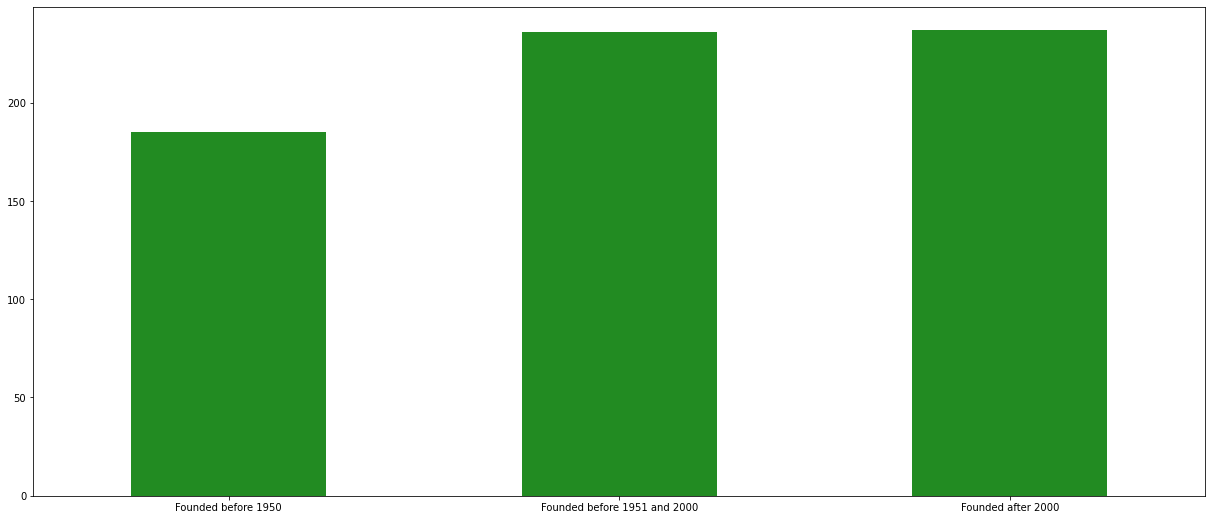

In [20]:
train[['Founded before 1950', 'Founded before 1951 and 2000', 'Founded after 2000']].sum().plot.bar(figsize=wide, rot=0, color='forestgreen');

In [21]:
train.head()

,Rating,Type of ownership,Sector,Revenue,hourly,employer_provided,avg_salary,python_yn,R_yn,spark,...,num_comp,10000+ employees,1001 to 5000 employees,201 to 500 employees,5001 to 10000 employees,501 to 1000 employees,0 to 500 employees,Founded before 1950,Founded before 1951 and 2000,Founded after 2000
0,3.8,Company - Private,Aerospace & Defense,$50 to $100 million (USD),0,0,72.0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,3.4,Other Organization,Health Care,$2 to $5 billion (USD),0,0,87.5,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,4.8,Company - Private,Business Services,$100 to $500 million (USD),0,0,85.0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,3.8,Government,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),0,0,76.5,1,0,0,...,3,0,1,0,0,0,0,0,1,0
4,2.9,Company - Private,Business Services,Unknown / Non-Applicable,0,0,114.5,1,0,0,...,3,0,0,0,0,0,1,0,1,0


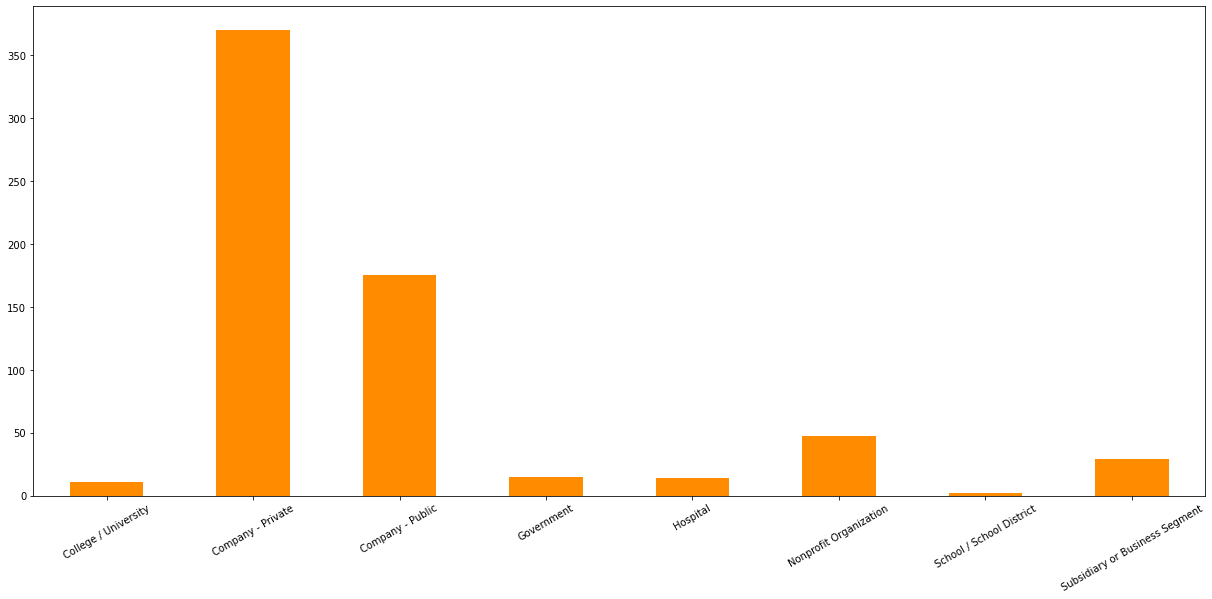

In [22]:
Type_dummy = pd.get_dummies(train['Type of ownership']).drop(['-1', 'Unknown', 'Other Organization'], axis=1)
Type_dummy.sum().plot.bar(figsize=wide, rot=30,color='darkorange');

In [23]:
Type_dummy['Public entity'] = Type_dummy['College / University'] + Type_dummy['Hospital'] + Type_dummy['Company - Public'] + Type_dummy['Government'] + Type_dummy['School / School District']
Type_dummy.drop(columns={'College / University', 'Hospital', 'Company - Public', 'School / School District', 'Government'}, inplace=True)

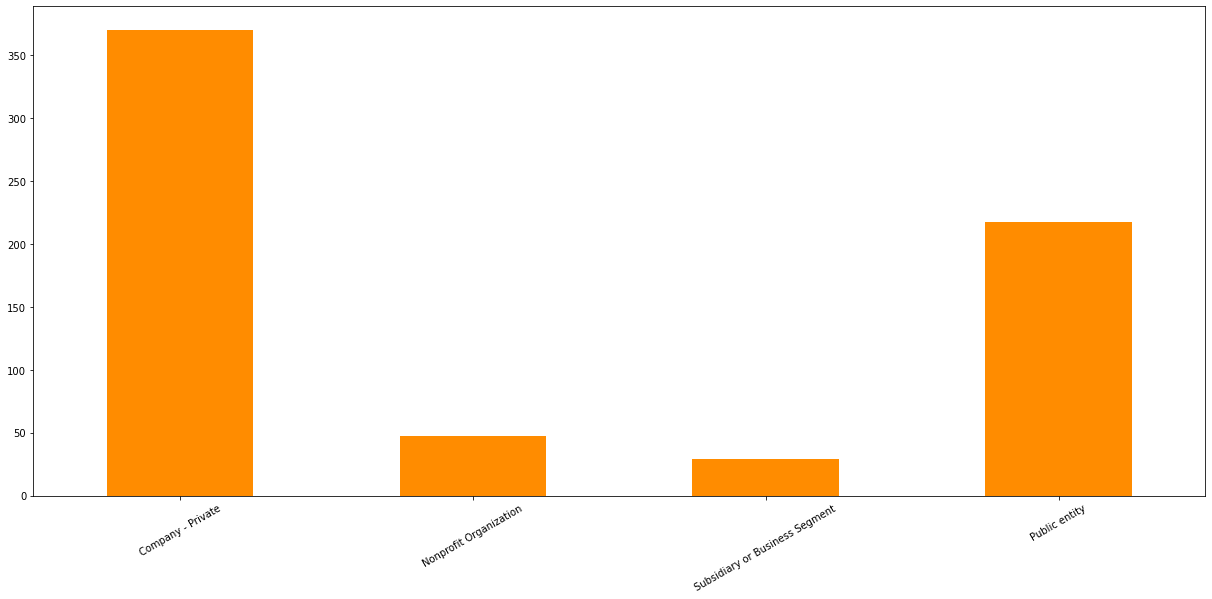

In [24]:
Type_dummy.sum().plot.bar(figsize=wide, rot=30,color='darkorange');

In [25]:
train = pd.concat([train.drop('Type of ownership', axis=1), Type_dummy], axis=1)

In [26]:
train.head()

,Rating,Sector,Revenue,hourly,employer_provided,avg_salary,python_yn,R_yn,spark,aws,...,5001 to 10000 employees,501 to 1000 employees,0 to 500 employees,Founded before 1950,Founded before 1951 and 2000,Founded after 2000,Company - Private,Nonprofit Organization,Subsidiary or Business Segment,Public entity
0,3.8,Aerospace & Defense,$50 to $100 million (USD),0,0,72.0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
1,3.4,Health Care,$2 to $5 billion (USD),0,0,87.5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,4.8,Business Services,$100 to $500 million (USD),0,0,85.0,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0
3,3.8,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),0,0,76.5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,2.9,Business Services,Unknown / Non-Applicable,0,0,114.5,1,0,0,0,...,0,0,1,0,1,0,1,0,0,0


In [27]:
train.Revenue.unique()

array(['$50 to $100 million (USD)', '$2 to $5 billion (USD)',
       '$100 to $500 million (USD)', '$500 million to $1 billion (USD)',
       'Unknown / Non-Applicable', '$1 to $2 billion (USD)',
       '$25 to $50 million (USD)', '$10+ billion (USD)',
       '$1 to $5 million (USD)', '$10 to $25 million (USD)',
       '$5 to $10 billion (USD)', 'Less than $1 million (USD)',
       '$5 to $10 million (USD)', '-1'], dtype=object)

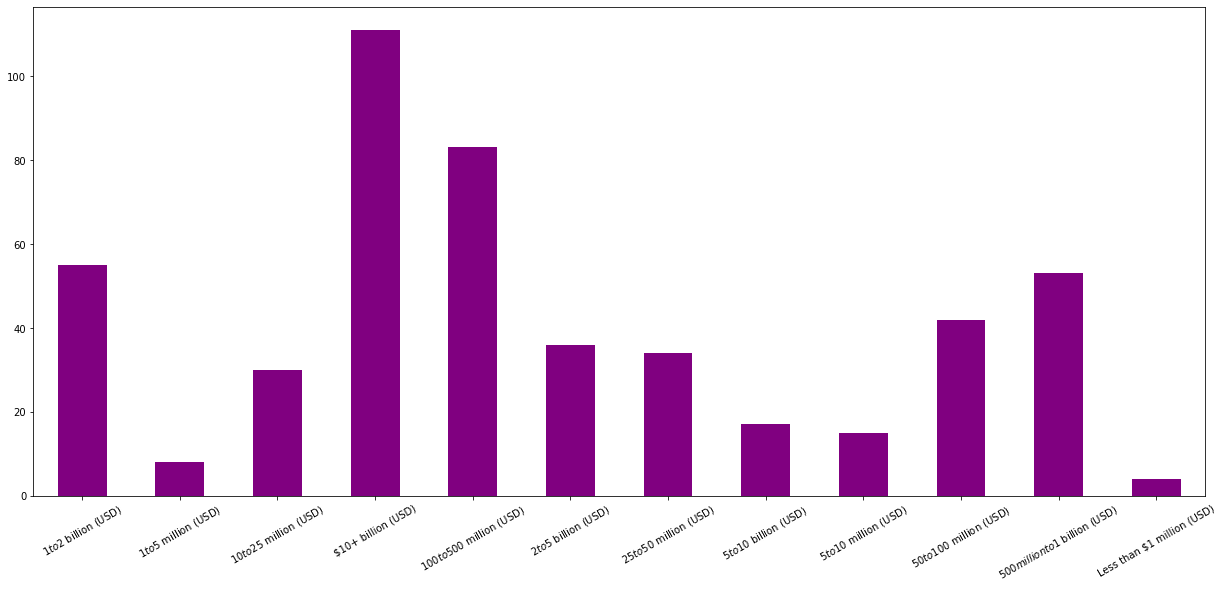

In [28]:
Revenue_dummy = pd.get_dummies(train.Revenue).drop(['Unknown / Non-Applicable', '-1'], axis=1)
Revenue_dummy.sum().plot.bar(figsize=wide, color='purple', rot=30);

In [29]:
Revenue_dummy['$1 to $50 million (USD)'] = Revenue_dummy['Less than $1 million (USD)'] + Revenue_dummy['$1 to $5 million (USD)'] + Revenue_dummy['$5 to $10 million (USD)'] + Revenue_dummy['$10 to $25 million (USD)'] + Revenue_dummy['$25 to $50 million (USD)']
Revenue_dummy['$500 million to $10 billion (USD)'] = Revenue_dummy['$500 million to $1 billion (USD)'] + Revenue_dummy['$1 to $2 billion (USD)'] + Revenue_dummy['$2 to $5 billion (USD)'] + Revenue_dummy['$5 to $10 billion (USD)']

Revenue_dummy.drop(columns={'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $10 million (USD)', '$10 to $25 million (USD)', '$25 to $50 million (USD)',
    '$500 million to $1 billion (USD)', '$1 to $2 billion (USD)', '$2 to $5 billion (USD)', '$5 to $10 billion (USD)'}, inplace=True)

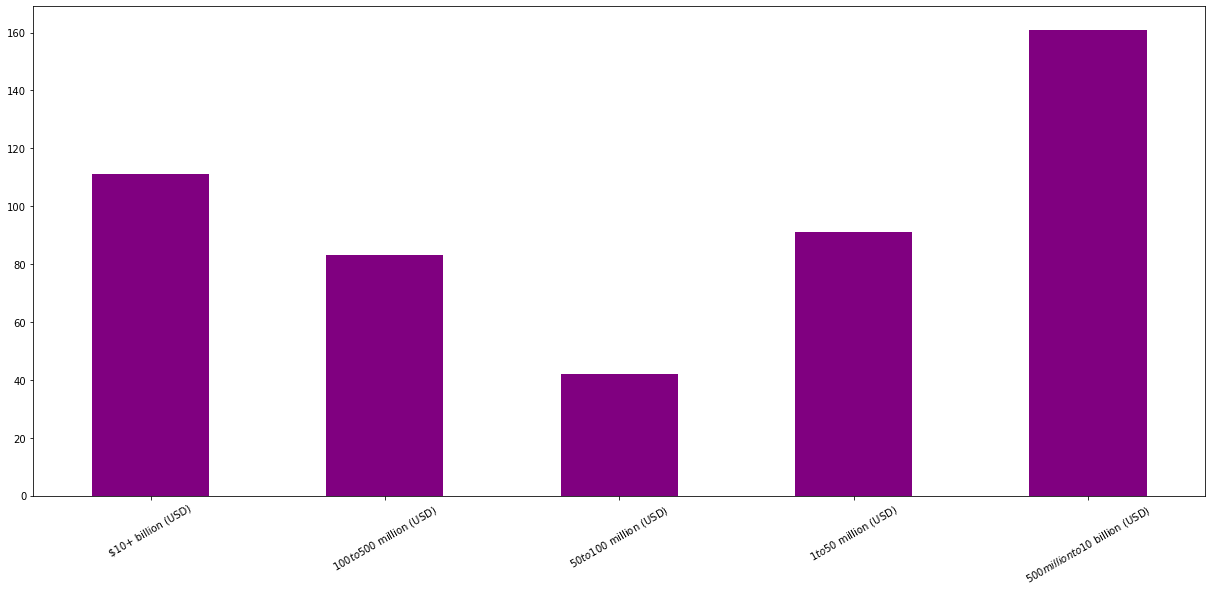

In [30]:
Revenue_dummy.sum().plot.bar(figsize=wide, color='purple', rot=30);

In [31]:
train = pd.concat([train.drop('Revenue', axis=1), Revenue_dummy], axis=1)
# train.drop('Revenue', axis=1, inplace=True)

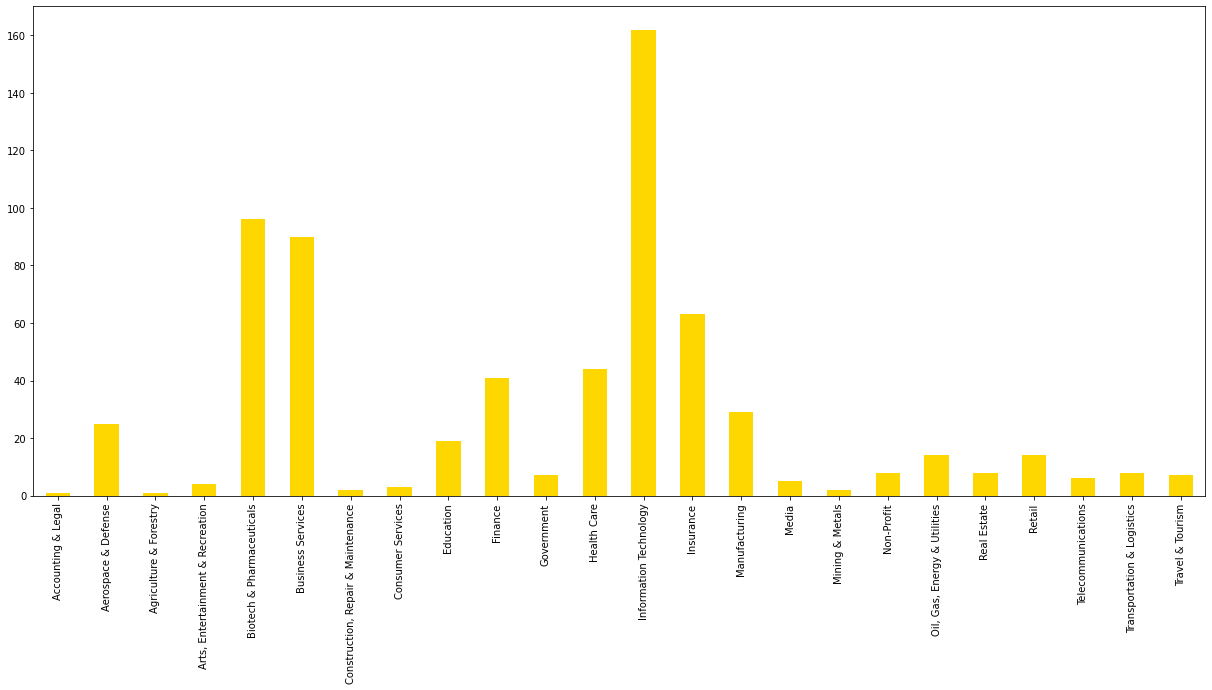

In [32]:
Sector_dummy = pd.get_dummies(train.Sector).drop('-1', axis=1)
Sector_dummy.sum().plot.bar(figsize=wide, color='gold', rot=90);

In [33]:
Sector_dummy['Tech'] = Sector_dummy['Aerospace & Defense'] + Sector_dummy['Information Technology'] + Sector_dummy['Telecommunications']
Sector_dummy['Raw Materials / First Utilities'] = Sector_dummy['Oil, Gas, Energy & Utilities'] + Sector_dummy['Mining & Metals'] + Sector_dummy['Agriculture & Forestry'] + Sector_dummy['Transportation & Logistics'] + Sector_dummy['Construction, Repair & Maintenance']
Sector_dummy['Health'] = Sector_dummy['Health Care'] + Sector_dummy['Biotech & Pharmaceuticals']
Sector_dummy['Entertainment'] = Sector_dummy['Travel & Tourism'] + Sector_dummy['Arts, Entertainment & Recreation']
Sector_dummy['Business'] = Sector_dummy['Business Services'] + Sector_dummy['Finance'] + Sector_dummy['Real Estate'] + Sector_dummy['Insurance']
Sector_dummy['Retail / Manufacturing'] =  Sector_dummy['Retail'] + Sector_dummy['Manufacturing'] + Sector_dummy['Consumer Services']
Sector_dummy['Legal / Government'] = Sector_dummy['Accounting & Legal'] + Sector_dummy['Government']

Sector_dummy.drop(columns={'Aerospace & Defense', 'Information Technology', 'Telecommunications',
    'Oil, Gas, Energy & Utilities', 'Mining & Metals', 'Agriculture & Forestry', 'Transportation & Logistics', 'Construction, Repair & Maintenance',
    'Health Care', 'Biotech & Pharmaceuticals',
    'Travel & Tourism', 'Arts, Entertainment & Recreation',
    'Retail', 'Manufacturing', 'Consumer Services',
    'Business Services', 'Finance', 'Real Estate', 'Insurance',
    'Accounting & Legal', 'Government'}, inplace=True)

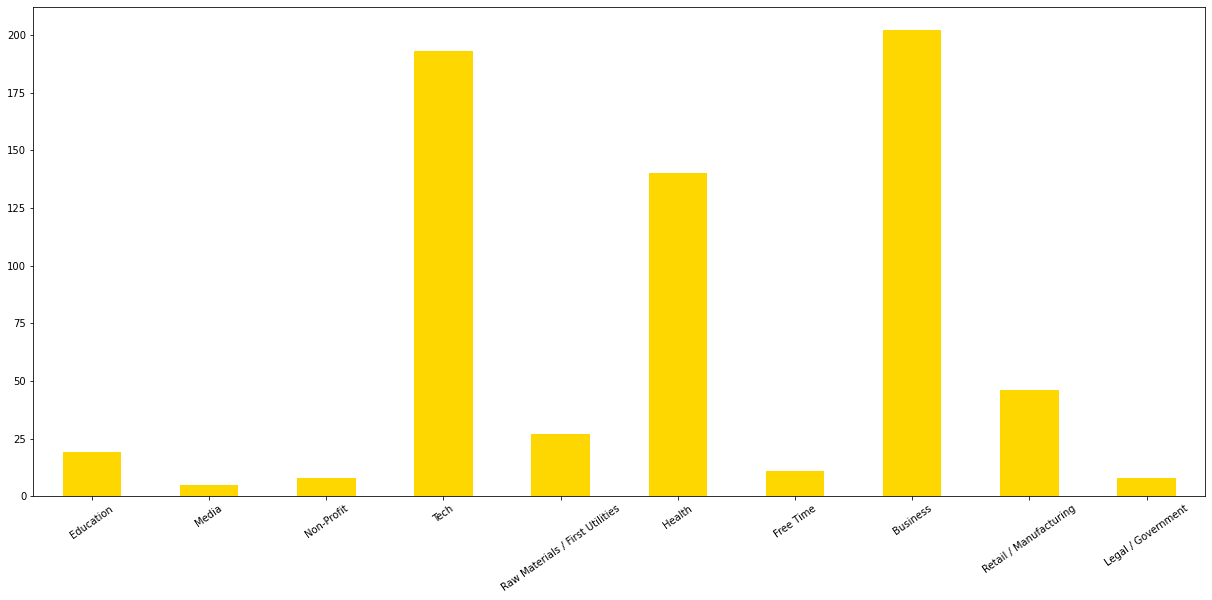

In [34]:
# train.Sector.unique().shape
Sector_dummy.sum().plot.bar(figsize=wide, color='gold', rot=35);

In [35]:
train = pd.concat([train.drop('Sector', axis=1), Sector_dummy], axis=1)

In [36]:
train.Rating.replace(-1, np.NaN, inplace=True) # replacing the -1 with NaN, so if we calculate the mean of the distirbution it is not afected by them.
train.fillna(train.Rating.mean(), inplace=True) # Then impute the mean of the age distribution in the null values.
train.Rating = MinMaxScaler().fit_transform(np.array(train.Rating).reshape(-1, 1)) # Scaling the values of the Rating into [0,1], so they have the same weight as the rest: from 0 to 1.

In [37]:
train.head()

,Rating,hourly,employer_provided,avg_salary,python_yn,R_yn,spark,aws,excel,job_simp,...,Education,Media,Non-Profit,Tech,Raw Materials / First Utilities,Health,Free Time,Business,Retail / Manufacturing,Legal / Government
0,0.612903,0,0,72.0,1,0,0,0,1,data scientist,...,0,0,0,1,0,0,0,0,0,0
1,0.483871,0,0,87.5,1,0,0,0,0,data scientist,...,0,0,0,0,0,1,0,0,0,0
2,0.935484,0,0,85.0,1,0,1,0,1,data scientist,...,0,0,0,0,0,0,0,1,0,0
3,0.612903,0,0,76.5,1,0,0,0,0,data scientist,...,0,0,0,0,1,0,0,0,0,0
4,0.322581,0,0,114.5,1,0,0,0,1,data scientist,...,0,0,0,0,0,0,0,1,0,0


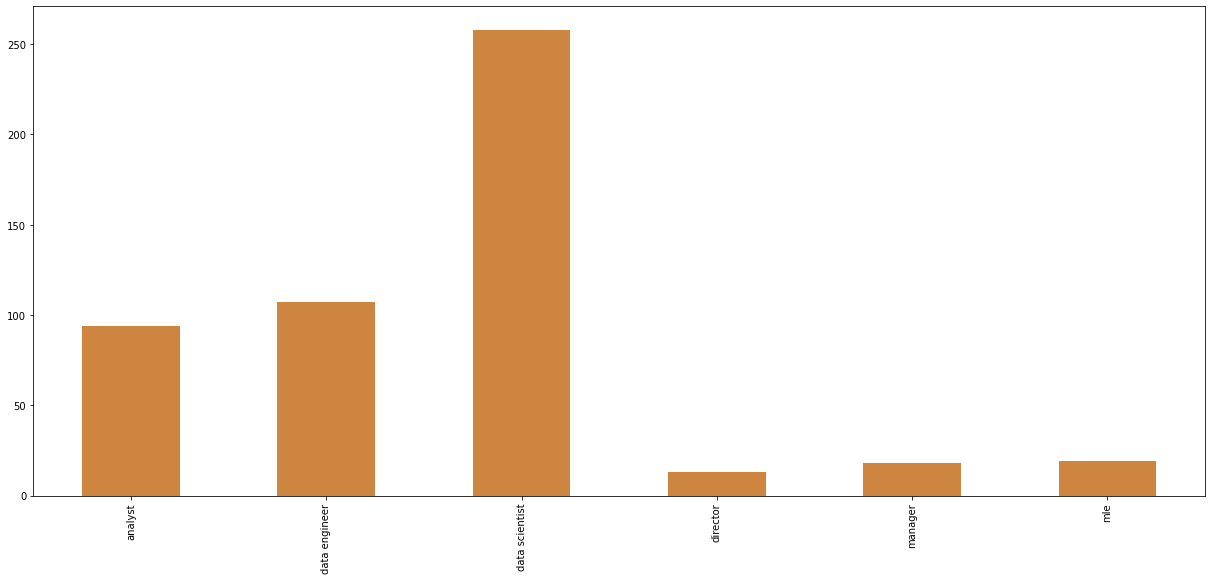

In [38]:
job_dummy = pd.get_dummies(train.job_simp).drop('na', axis=1)

job_dummy.sum().plot.bar(figsize=wide, color='peru'); # Where mle refers to Machine Learning Expert.

In [39]:
train = pd.concat([train.drop('job_simp', axis=1), job_dummy], axis=1)

In [40]:
train.columns

Index(['Rating', 'hourly', 'employer_provided', 'avg_salary', 'python_yn',
       'R_yn', 'spark', 'aws', 'excel', 'seniority', 'num_comp',
       '10000+ employees', '1001 to 5000 employees', '201 to 500 employees',
       '5001 to 10000 employees', '501 to 1000 employees',
       '0 to 500 employees', 'Founded before 1950',
       'Founded before 1951 and 2000', 'Founded after 2000',
       'Company - Private', 'Nonprofit Organization',
       'Subsidiary or Business Segment', 'Public entity', '$10+ billion (USD)',
       '$100 to $500 million (USD)', '$50 to $100 million (USD)',
       '$1 to $50 million (USD)', '$500 million to $10 billion (USD)',
       'Education', 'Media', 'Non-Profit', 'Tech',
       'Raw Materials / First Utilities', 'Health', 'Free Time', 'Business',
       'Retail / Manufacturing', 'Legal / Government', 'analyst',
       'data engineer', 'data scientist', 'director', 'manager', 'mle'],
      dtype='object')

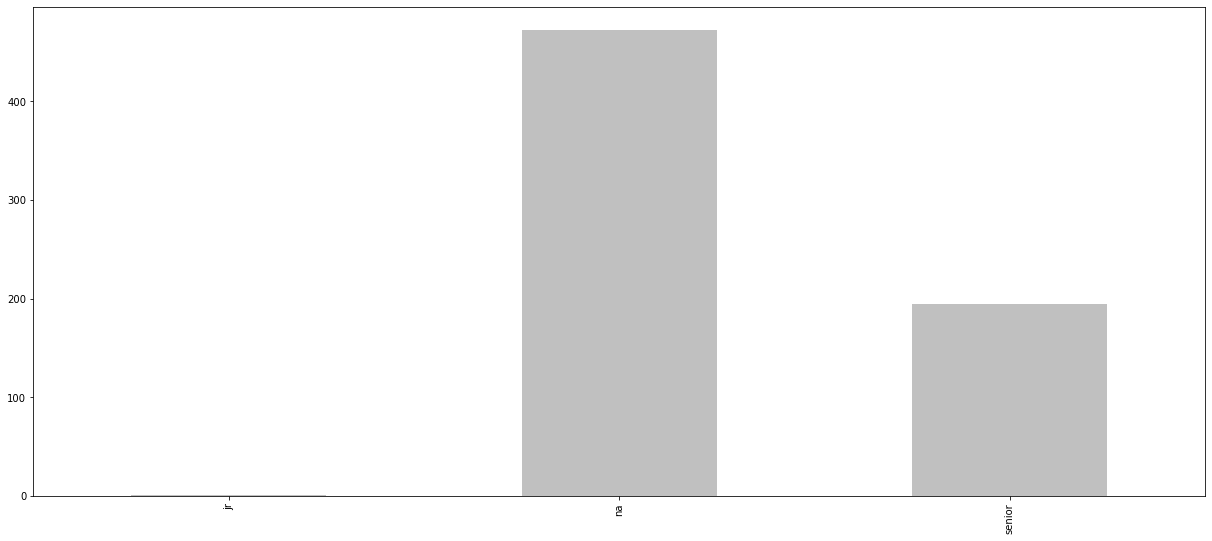

In [41]:
pd.get_dummies(train.seniority).sum().plot.bar(figsize=wide, color='silver');

We see how the bast majority of the jobs do not have a defined seniority therefore we must drop it.

In [42]:
train.drop('seniority', axis=1, inplace=True)

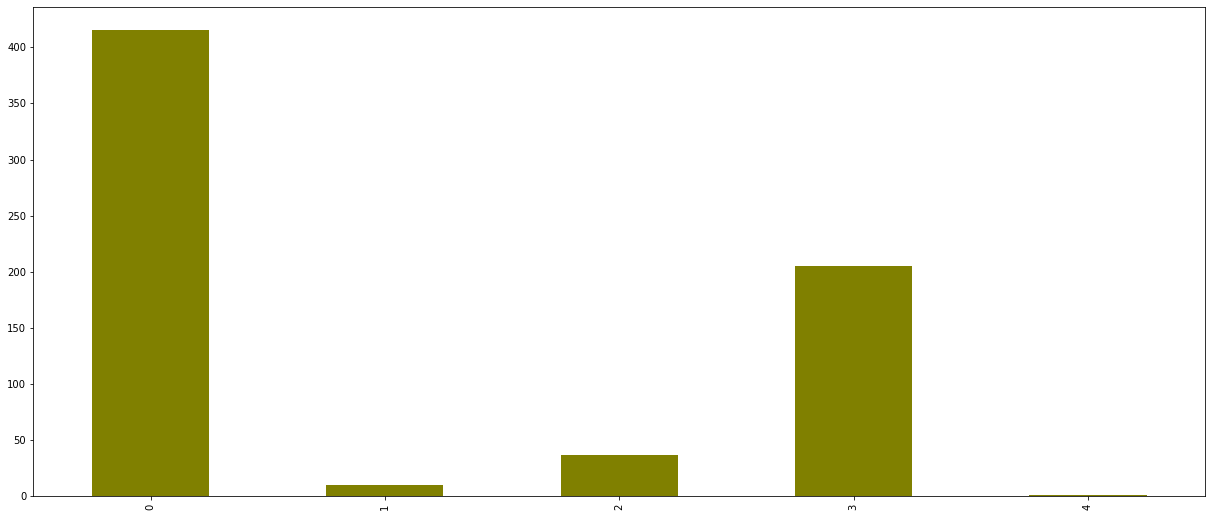

In [43]:
Num_com_dummy = pd.get_dummies(train.num_comp)

Num_com_dummy.sum().plot.bar(figsize=wide, color='olive', rot=90);

In [44]:
Num_com_dummy['No Competence'] = Num_com_dummy[0]
Num_com_dummy['Competence'] = Num_com_dummy[[1,2,3,4]].sum(axis=1)

Num_com_dummy.drop(columns={0,1,2,3,4}, inplace=True)

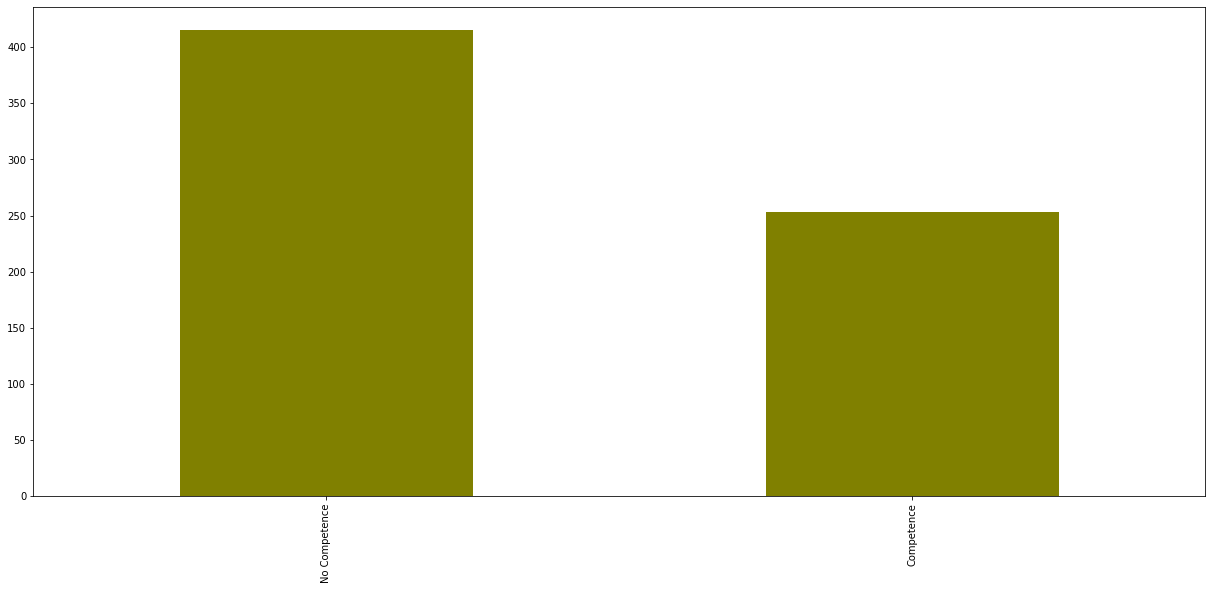

In [45]:
Num_com_dummy.sum().plot.bar(figsize=wide, color='olive');

In [46]:
train = pd.concat([train.drop('num_comp', axis=1), Num_com_dummy], axis=1)

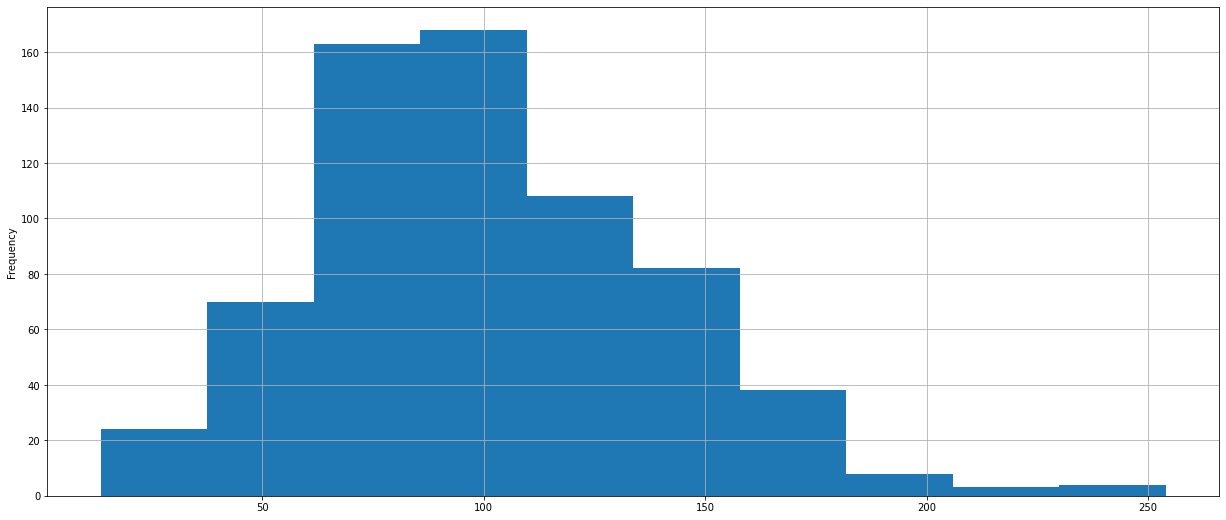

In [47]:
train.avg_salary.plot(kind='hist', figsize=wide, grid=True); # We do not observe outliers in the Average Salary:

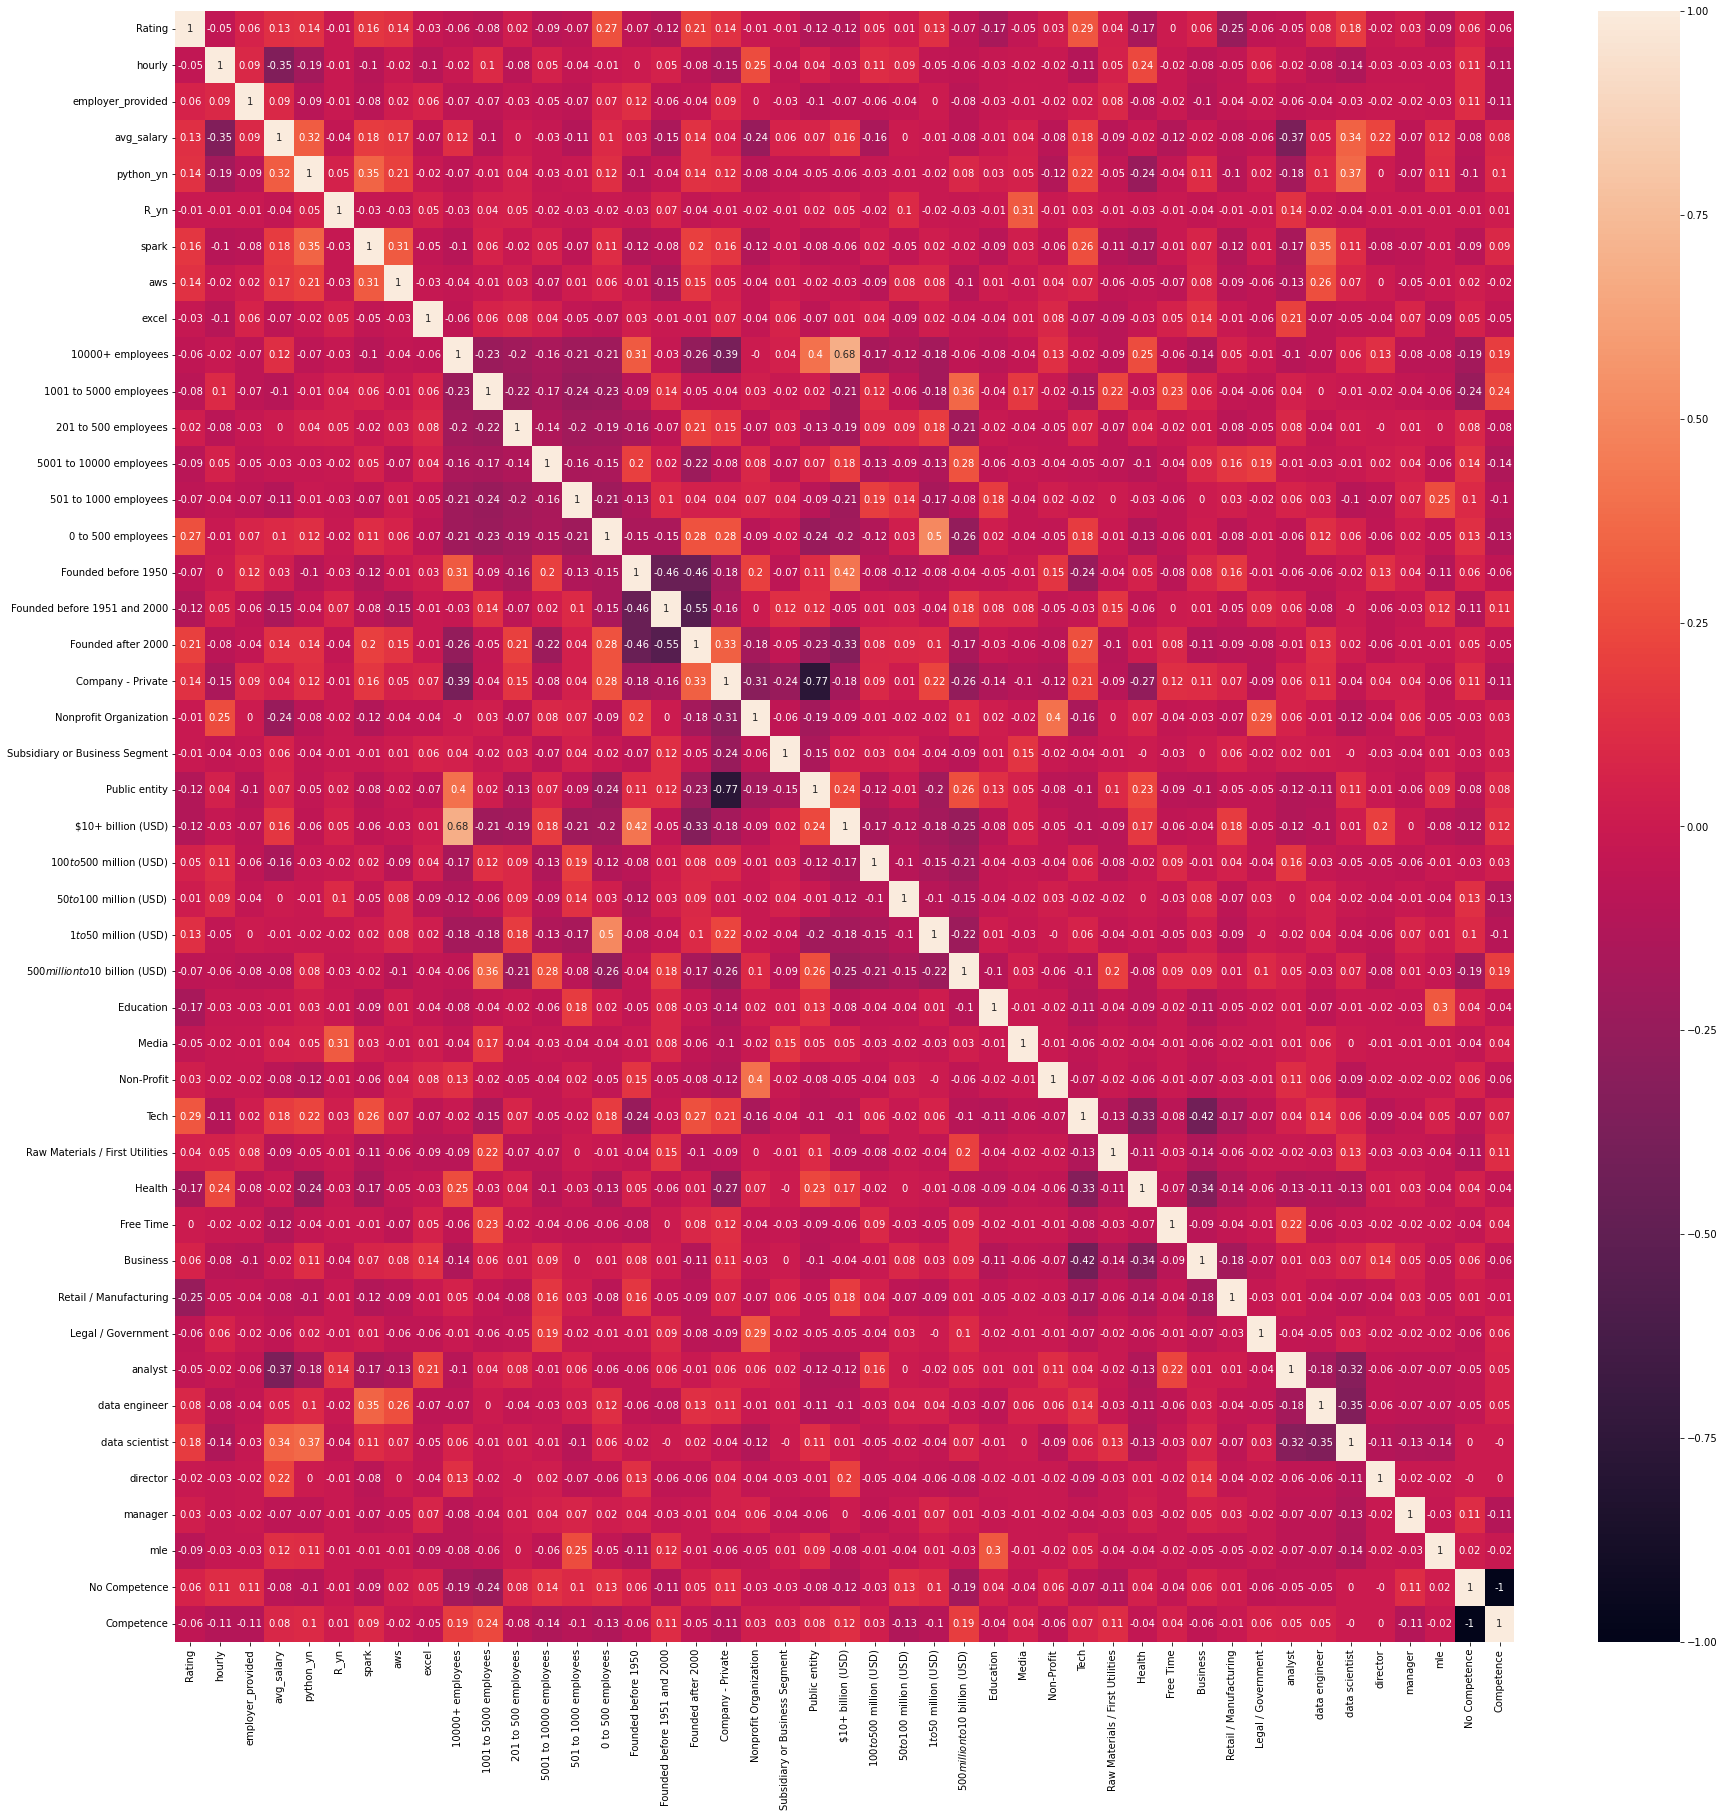

In [48]:
corr_matrix = train.corr()

fig, ax = plt.subplots(figsize=large_square)
heatmap(train.corr().round(2), annot=True);

In [57]:
train.tail()

,Rating,hourly,employer_provided,avg_salary,python_yn,R_yn,spark,aws,excel,10000+ employees,...,Business,Retail / Manufacturing,Legal / Government,analyst,data engineer,data scientist,director,manager,mle,No Competence
663,0.548387,0,0,48.5,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
664,0.580645,0,0,87.0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,1
665,0.483871,0,0,80.0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
666,0.677419,1,0,21.5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
667,0.580645,0,0,173.0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


### Correlation:

In order to reduce the dimension of the dataframe we can study the correlation of the variables, if two variables have a high correlation they sourcing the model the same information hence we can use one of the pair.

We will say that a pair of variables have an strong correlation when |corr| >∼ 0.7. In this case:

* No Competence / Competence: -1
* Public Entity / Company Private: -0.77
* 10+ billion / +1000 employees: +0.68

In [50]:
train.drop(['Public entity', '$10+ billion (USD)', 'Competence'], axis=1, inplace=True) # Getting rid of the variables with high correlation.

### Model Selection and Hyperparameter tuning:

After the preprocessing of the train data the next step is to find which model are we going to implement in order to face the problem. In this case, our list of regression models:

* Random Forest Regressor
* Support Vector Machine Regressor
* Linear Regressor
* Gradient Boost Regressor

We wil study their performance under a Cross Validation Scoring scenario (using the metric R2) and select the model with best performance with the default hyperparameters. 

Once that we select the model its time to the hyperparameter tuning stage. Applying the Grid Search CV technique we will try with different combinations of hyperparameters looking to improve the performance respecting to the default model.

In [51]:
rfr = RandomForestRegressor()
svr = SVR() # Support Vector Regressor
lr = LinearRegression()
gbr = GradientBoostingRegressor()

In [52]:
cross_val_score(rfr, train.drop('avg_salary', axis=1), train.avg_salary, cv=5,  scoring='r2').mean()

0.5365282543417085

In [53]:
cross_val_score(gbr, train.drop('avg_salary', axis=1), train.avg_salary, cv=5,  scoring='r2').mean()

0.4596824548700383

In [54]:
cross_val_score(svr, train.drop('avg_salary', axis=1), train.avg_salary, cv=5,  scoring='r2').mean()

0.12658276449128003

In [55]:
cross_val_score(lr, train.drop('avg_salary', axis=1), train.avg_salary, cv=5,  scoring='r2').mean()

0.40111308086105124

#### Conclusion:

By the default hyperparameters models we are able to get a maximun of $R2 \ \sim 0.54$, which is not consider a good performance of the model.

In order to increase the performance of our selected model we will tune the hyperparameters:

In [ ]:
rf_param_grid = {
    'max_features' : range(3, 8, 1),
    'n_jobs': [-1],
    'n_estimators': [200],
    'random_state': np.random.randint(0, 100, 20)
} # Avoid overfitting by fixing the max depth of the trees.

rf_grid = GridSearchCV(rfr, rf_param_grid, scoring='r2', verbose=3)
rf_grid.fit(train.drop('avg_salary', axis=1), train.avg_salary)

In [ ]:
rf_grid.best_score_

In [ ]:
rf_grid.best_estimator_

### First Conclusions:

As we can see our model give us a very poor prediction, so, in order to improve the model, we will treat the data and put the focus in a number of less parameters but the ones we are most interested to see how they influence the average salary of a Data Science related job: